# How to use TF-TRT example: ResNetV2 FP16
The goal is to demonstrate how to TF-TRT FP16/FP32 APIs.


In [ ]:
import os
os.environ["TF_CPP_VMODULE"]="trt_engine_utils=2,trt_engine_op=2,convert_nodes=2,convert_graph=2,segment=2,trt_shape_optimization_profiles=2,trt_engine_resource_ops=2"

In [ ]:
!pip install pillow matplotlib

In [ ]:
import tensorflow as tf
import numpy as np
from timeit import default_timer as timer

from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.framework import convert_to_constants
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

## Load and save the TF model

In [ ]:
model = ResNet50V2(weights='imagenet') 
tf.saved_model.save(model, '/tmp/data/resnet_v2_50_saved_model')

/usr/local/google/_blaze_bixia/ecaf085a047e052ca9816de7c4376984/execroot/google3/blaze-out/k8-cuda11-fastbuild/bin/learning/deepmind/public/tools/ml_python/ml_notebook.runfiles/google3/third_party/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Helper functions

In [ ]:
def get_func_from_saved_model(saved_model_dir):
    saved_model_loaded = tf.saved_model.load(
        saved_model_dir, tags=[tag_constants.SERVING])
    graph_func = saved_model_loaded.signatures[
        signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
    return graph_func, saved_model_loaded

In [ ]:
def predict_and_benchmark_throughput(batched_input, model, N_warmup_run=50, N_run=500,
                                     result_key='predictions', batch_size=None):
    elapsed_time = []
    all_preds = []
    
    if batch_size is None or batch_size > batched_input.shape[0]:
        batch_size = batched_input.shape[0]
    print('Benchmarking with batch size', batch_size)
    
    elapsed_time = np.zeros(N_run)
    for i in range(N_warmup_run):                                             
        preds = model(batched_input)
    
    # Force device synchronization with .numpy()
    tmp = preds[result_key][0,0].numpy() 
    
    for i in range(N_run):
        start_time = timer()
        preds = model(batched_input)
        # Synchronize
        tmp += preds[result_key][0,0].numpy() 
        end_time = timer()
        elapsed_time[i] = end_time - start_time
        all_preds.append(preds)

        if i>=50 and i % 50 == 0:
            print('Steps {}-{} average: {:4.1f}ms'.format(i-50, i, (elapsed_time[i-50:i].mean()) * 1000))

    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))
    return all_preds

In [ ]:
def get_dummy_images(batch_size = 32, img_shape = [224, 224, 3]):
    img=tf.random.uniform(shape=[batch_size] + img_shape, dtype=tf.float32)
    print("Generated input random images with shape (N, H, W, C) =", img.shape)
    return img

## Input data
Get some images from the web that will be used for testing the model

In [ ]:
!mkdir /tmp/data
!wget  -O /tmp/data/img0.JPG "https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630"
!wget  -O /tmp/data/img1.JPG "https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg"
!wget  -O /tmp/data/img2.JPG "https://www.artis.nl/media/filer_public_thumbnails/filer_public/00/f1/00f1b6db-fbed-4fef-9ab0-84e944ff11f8/chimpansee_amber_r_1920x1080.jpg__1920x1080_q85_subject_location-923%2C365_subsampling-2.jpg"
!wget  -O /tmp/data/img3.JPG "https://www.familyhandyman.com/wp-content/uploads/2018/09/How-to-Avoid-Snakes-Slithering-Up-Your-Toilet-shutterstock_780480850.jpg"

mkdir: cannot create directory ‘/tmp/data’: File exists
--2021-03-29 16:46:49--  https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630
Resolving d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)... 52.85.90.209, 52.85.90.77, 52.85.90.5, ...
Connecting to d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)|52.85.90.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24112 (24K) [image/jpeg]
Saving to: ‘/tmp/data/img0.JPG’

     0K .......... .......... ...                             100% 1.92M=0.01s

2021-03-29 16:46:49 (1.92 MB/s) - ‘/tmp/data/img0.JPG’ saved [24112/24112]

--2021-03-29 16:46:49--  https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg
Resolving www.hakaimagazine.com (www.hakaimagazine.com)... 2620:12a:8001::4, 2620:12a:8000::4, 23.185.0.4
Connecting to www.hakaimagazine.com (www.hakaimagazine.com)|2620:12a:8001::4|:443... connected.
HTTP request s

Plot the images

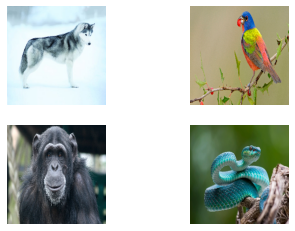

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions

fig, axes = plt.subplots(nrows=2, ncols=2)

for i in range(4):
  img_path = '/tmp/data/img%d.JPG'%i
  img = image.load_img(img_path, target_size=(224, 224))
  plt.subplot(2,2,i+1)
  plt.imshow(img);
  plt.axis('off');

We will also use a batch of random pixels

In [ ]:
input = get_dummy_images(32)

Generated input random images with shape (N, H, W, C) = (32, 224, 224, 3)


## Run inference with TF

In [ ]:
func, _ = get_func_from_saved_model('/tmp/data/resnet_v2_50_saved_model')

output = func(input)

print('output shape',output['predictions'].shape)

res = predict_and_benchmark_throughput(input, func)

output shape (32, 1000)
Benchmarking with batch size 32
Steps 0-50 average: 35.9ms
Steps 50-100 average: 35.7ms
Steps 100-150 average: 35.5ms
Steps 150-200 average: 35.6ms
Steps 200-250 average: 35.5ms
Steps 250-300 average: 35.6ms
Steps 300-350 average: 35.6ms
Steps 350-400 average: 35.7ms
Steps 400-450 average: 35.4ms
Throughput: 898 images/s


Test the model on real data

In [ ]:
def infer_real_images(func, img_shape=(224,224)):
    for i in range(4):
        img_path = '/tmp/data/img%d.JPG'%i
        img = image.load_img(img_path, target_size=img_shape)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
    
        preds = func(tf.convert_to_tensor(x))['predictions'].numpy()
        # decode the results into a list of tuples (class, description, probability)
        # (one such list for each sample in the batch)
        print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))

        plt.subplot(2,2,i+1)
        plt.imshow(img);
        plt.axis('off');
        plt.title(decode_predictions(preds, top=3)[0][0][1])

/tmp/data/img0.JPG - Predicted: [('n02110063', 'malamute', 0.7264924), ('n02110185', 'Siberian_husky', 0.23268329), ('n02109961', 'Eskimo_dog', 0.04082151)]
/tmp/data/img1.JPG - Predicted: [('n01820546', 'lorikeet', 0.9193418), ('n01828970', 'bee_eater', 0.038710535), ('n01818515', 'macaw', 0.029649049)]
/tmp/data/img2.JPG - Predicted: [('n02481823', 'chimpanzee', 0.9984586), ('n02480495', 'orangutan', 0.0006370447), ('n02480855', 'gorilla', 0.00031307686)]
/tmp/data/img3.JPG - Predicted: [('n01729977', 'green_snake', 0.7426864), ('n01749939', 'green_mamba', 0.19934022), ('n01739381', 'vine_snake', 0.026502712)]


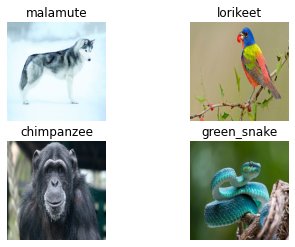

In [ ]:
infer_real_images(func)

## Convert the model with TF-TRT

In [ ]:
def trt_convert(input_path, output_path, input_shapes):
    conv_params=trt.TrtConversionParams(
        precision_mode='FP16', minimum_segment_size=3,
        max_workspace_size_bytes=1<<30, maximum_cached_engines=1)
    converter = trt.TrtGraphConverterV2(
        input_saved_model_dir=input_path, conversion_params=conv_params, use_dynamic_shape=True, dynamic_shape_profile_strategy="Range")                 

    converter.convert()
    def input_fn():
        for shapes in input_shapes:
            # return a list of input tensors
            yield [np.ones(shape=x).astype(np.float32) for x in shapes]

    converter.build(input_fn)
    converter.save(output_path)

Convert to TF-TRT with FP16

In [ ]:
trt_convert(input_path="/tmp/data/resnet_v2_50_saved_model", output_path="/tmp/data/resnet_v2_50_trt",
            input_shapes=[[input.shape]])

### Load converted model and check difference

In [ ]:
trt_func, _ = get_func_from_saved_model('/tmp/data/resnet_v2_50_trt')

trt_output = trt_func(input)

In [ ]:
diff = output['predictions'] - trt_output['predictions']
np.max(np.abs(diff.numpy()))
# Note: it might not make sense to check difference for output generated from random noise.

1.5646219e-06

Test the the converted model on real images

/tmp/data/img0.JPG - Predicted: [('n02110063', 'malamute', 0.72649235), ('n02110185', 'Siberian_husky', 0.23268327), ('n02109961', 'Eskimo_dog', 0.04082159)]
/tmp/data/img1.JPG - Predicted: [('n01820546', 'lorikeet', 0.9193418), ('n01828970', 'bee_eater', 0.03871046), ('n01818515', 'macaw', 0.029649077)]
/tmp/data/img2.JPG - Predicted: [('n02481823', 'chimpanzee', 0.9984586), ('n02480495', 'orangutan', 0.0006370471), ('n02480855', 'gorilla', 0.00031307776)]
/tmp/data/img3.JPG - Predicted: [('n01729977', 'green_snake', 0.74268556), ('n01749939', 'green_mamba', 0.19934075), ('n01739381', 'vine_snake', 0.02650273)]


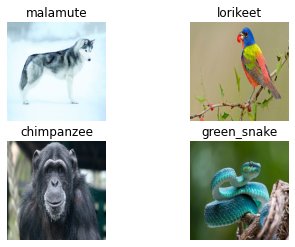

In [ ]:
infer_real_images(trt_func)

## Benchmark converted model

In [ ]:
res = predict_and_benchmark_throughput(input, trt_func)

Benchmarking with batch size 32
Steps 0-50 average: 36.5ms
Steps 50-100 average: 36.5ms
Steps 100-150 average: 36.5ms
Steps 150-200 average: 36.5ms
Steps 200-250 average: 36.5ms
Steps 250-300 average: 36.6ms
Steps 300-350 average: 36.6ms
Steps 350-400 average: 36.6ms
Steps 400-450 average: 36.6ms
Throughput: 876 images/s


Check with different batch sizes

In [ ]:
input1 = get_dummy_images(1)
res = predict_and_benchmark_throughput(input1, trt_func)

input8 = get_dummy_images(8)
res = predict_and_benchmark_throughput(input8, trt_func)

Generated input random images with shape (N, H, W, C) = (1, 224, 224, 3)
Benchmarking with batch size 1
Steps 0-50 average:  2.2ms
Steps 50-100 average:  2.2ms
Steps 100-150 average:  2.2ms
Steps 150-200 average:  2.2ms
Steps 200-250 average:  2.2ms
Steps 250-300 average:  2.2ms
Steps 300-350 average:  2.2ms
Steps 350-400 average:  2.2ms
Steps 400-450 average:  2.2ms
Throughput: 453 images/s
Generated input random images with shape (N, H, W, C) = (8, 224, 224, 3)
Benchmarking with batch size 8
Steps 0-50 average:  3.1ms
Steps 50-100 average:  3.1ms
Steps 100-150 average:  3.1ms
Steps 150-200 average:  3.1ms
Steps 200-250 average:  3.1ms
Steps 250-300 average:  3.1ms
Steps 300-350 average:  3.1ms
Steps 350-400 average:  3.1ms
Steps 400-450 average:  3.1ms
Throughput: 2603 images/s
